# Population to nodes

Notebook which tests the SQL geometry query and the functions that download information from the database and assigns Census data to nodes.

## Import used modules

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Municipality GeoDataFrame

In [34]:
mun = ["15006", "15012", "15019", "15043", "15098", "15101"]
mun_gdf = gpd.GeoDataFrame()
gdf = aup.gdf_from_db("mpos_2020", "marco")
hex_bins = gpd.GeoDataFrame()

for m in mun:
    mun_gdf = mun_gdf.append(gdf.loc[gdf.CVEGEO == m])
    query = f"SELECT * FROM hexgrid.hex_grid WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))

<AxesSubplot:>

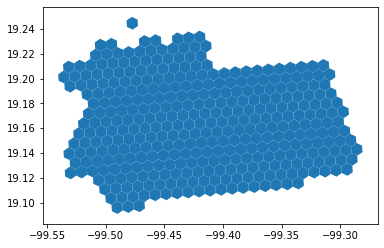

In [35]:
hex_bins.plot()

<AxesSubplot:>

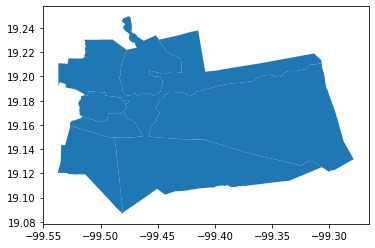

In [36]:
mun_gdf.plot()

## OSMnx nodes

In [5]:
# Reads mun_gdf GeoDataFrame as polygon
poly = mun_gdf.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

In [6]:
query = f"SELECT * FROM osmnx_new.nodes WHERE (\"x\" between \'{w}\' and \'{e}\') and (\"y\" between \'{s}\' and \'{n}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
nodes.head(2)

,osmid,x,y,street_count,geometry
0,8727742687,-102.114422,21.663346,1,POINT (-102.11442 21.66335)
1,8728228164,-102.319807,21.725714,3,POINT (-102.31981 21.72571)


<AxesSubplot:>

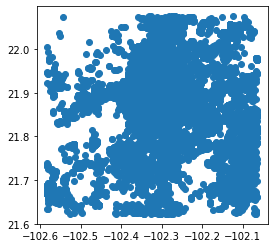

In [7]:
nodes.plot()

In [37]:
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

<AxesSubplot:>

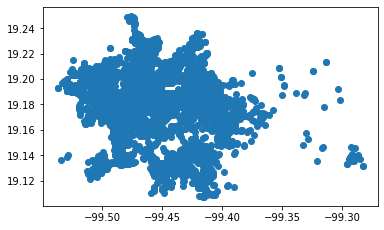

In [38]:
query = f"SELECT * FROM processed.nodes_dist_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
nodes.plot()

## AGEB

In [53]:
ageb_gdf = gpd.GeoDataFrame()

for m in mun:
    query = f"SELECT * FROM censoageb.censoageb_2020 WHERE \"cve_geo\" LIKE \'{m}%%\'"
    ageb_gdf = ageb_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

ageb_gdf = ageb_gdf.to_crs("EPSG:4326")
print(ageb_gdf.shape)
ageb_gdf.head(2)

(52, 237)


,cve_geo,cve_ent,cve_mun,cve_loc,cve_ageb,geometry,entidad,nom_ent,mun,nom_mun,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb
0,1500600010068,15,006,0001,0068,"POLYGON ((-99.48885 19.16159, -99.48918 19.161...",15,México,6,Almoloya del Río,...,160.0,91.0,81.0,17.0,13.0,9.0,16.0,80.0,4.0,1500600010068
1,1500600010049,15,006,0001,0049,"POLYGON ((-99.47917 19.17007, -99.47858 19.169...",15,México,6,Almoloya del Río,...,996.0,626.0,549.0,109.0,95.0,29.0,96.0,476.0,12.0,1500600010049


In [54]:
ageb_gdf.vph_s_elec.sum()

59.0

<AxesSubplot:>

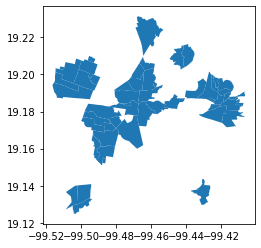

In [55]:
ageb_gdf.plot()

## Testing the functions

In [56]:
nodes_pop = aup.population_to_nodes(nodes, ageb_gdf, column_start=14, column_end=-2, cve_column='cve_geo')
#nodes_pop.drop('index_right', axis=1, inplace=True)
print(nodes_pop.shape)
nodes_pop.head(2)

(3865, 243)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados,cve_geo,cve_ent,cve_mun,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb
0,273577700,-99.428474,19.135765,POINT (-99.42847 19.13576),104.113,6837.787,6129.895,1510100030086,15,101,...,7.442308,3.115385,4.817308,0.605769,0.471154,0.326923,1.451923,5.596154,0.221154,1510100030086
8,1108410050,-99.429802,19.140358,POINT (-99.42980 19.14036),203.252,6231.117,5523.225,1510100030086,15,101,...,7.442308,3.115385,4.817308,0.605769,0.471154,0.326923,1.451923,5.596154,0.221154,1510100030086


## Hex bins

In [69]:
hex_bins = hex_bins.to_crs("EPSG:4326")
hex_temp = gpd.sjoin(nodes_pop, hex_bins)
print(hex_temp.shape)
hex_temp.head(2)

(3865, 246)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados,cve_geo,cve_ent,cve_mun,...,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb,index_right,hex_id_8,CVEGEO
0,273577700,-99.428474,19.135765,POINT (-99.42847 19.13576),104.113,6837.787,6129.895,1510100030086,15,101,...,0.605769,0.471154,0.326923,1.451923,5.596154,0.221154,1510100030086,26,8849864149fffff,15101
12,1108410124,-99.428724,19.133831,POINT (-99.42872 19.13383),278.136,7054.830,6346.938,1510100030086,15,101,...,0.605769,0.471154,0.326923,1.451923,5.596154,0.221154,1510100030086,26,8849864149fffff,15101


In [70]:
hex_temp.vph_s_elec.sum()

58.999999999999744

In [71]:
hex_temp.vph_s_elec

0       0.076923
12      0.076923
16      0.076923
24      0.076923
313     0.076923
          ...   
6375         NaN
6376         NaN
6377         NaN
6378         NaN
6544         NaN
Name: vph_s_elec, Length: 3865, dtype: object

In [72]:
string_columns = ['cve_geo','cve_ent','cve_mun','cve_loc','cve_ageb','entidad','nom_ent','mun','nom_mun','loc','nom_loc','ageb','mza','cve_geo_ageb','hex_id_8','CVEGEO']
hex_temp = aup.convert_type(hex_temp)
hex_temp.columns.to_list()

['osmid',
 'x',
 'y',
 'geometry',
 'dist_farmacia',
 'dist_hospitales',
 'dist_supermercados',
 'cve_geo',
 'cve_ent',
 'cve_mun',
 'cve_loc',
 'cve_ageb',
 'entidad',
 'nom_ent',
 'mun',
 'nom_mun',
 'loc',
 'nom_loc',
 'ageb',
 'mza',
 'pobtot',
 'pobfem',
 'pobmas',
 'p_0a2',
 'p_0a2_f',
 'p_0a2_m',
 'p_3ymas',
 'p_3ymas_f',
 'p_3ymas_m',
 'p_5ymas',
 'p_5ymas_f',
 'p_5ymas_m',
 'p_12ymas',
 'p_12ymas_f',
 'p_12ymas_m',
 'p_15ymas',
 'p_15ymas_f',
 'p_15ymas_m',
 'p_18ymas',
 'p_18ymas_f',
 'p_18ymas_m',
 'p_3a5',
 'p_3a5_f',
 'p_3a5_m',
 'p_6a11',
 'p_6a11_f',
 'p_6a11_m',
 'p_8a14',
 'p_8a14_f',
 'p_8a14_m',
 'p_12a14',
 'p_12a14_f',
 'p_12a14_m',
 'p_15a17',
 'p_15a17_f',
 'p_15a17_m',
 'p_18a24',
 'p_18a24_f',
 'p_18a24_m',
 'p_15a49_f',
 'p_60ymas',
 'p_60ymas_f',
 'p_60ymas_m',
 'rel_h_m',
 'pob0_14',
 'pob15_64',
 'pob65_mas',
 'prom_hnv',
 'pnacent',
 'pnacent_f',
 'pnacent_m',
 'pnacoe',
 'pnacoe_f',
 'pnacoe_m',
 'pres2015',
 'pres2015_f',
 'pres2015_m',
 'presoe15',
 'pr

In [73]:
resolution = 8
hex_temp = hex_temp.groupby(f'hex_id_{resolution}').sum()
hex_temp = hex_temp[ageb_gdf.iloc[:,14:-1].columns.to_list()]
print(hex_temp.shape)
hex_temp.head(2)

(77, 222)


,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,p_3ymas_m,p_5ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
hex_id_8,,,,,,,,,,,,,,,,,,,,,
8849864001fffff,4819.821131,2495.894799,2323.926333,223.195276,111.952977,111.242299,4596.625855,2383.941822,2212.684034,4427.868495,...,467.140972,970.490024,634.186776,543.625885,150.422908,102.166943,37.402716,92.412356,437.050482,18.723482
8849864003fffff,3089.021457,1591.189723,1497.831733,172.907397,80.831169,92.076228,2916.114060,1510.358554,1405.755505,2802.125353,...,241.067194,607.149068,375.531338,327.579898,64.653303,55.225296,20.736307,60.248447,294.915867,8.901186


Testing a one line alternative for the distribution of the population data within the nodes.

In [71]:
temp_oneline = temp[temp.iloc[:, 14:-2].columns.to_list()] / (temp.nodes_in.values.reshape((-1,1)))
temp_oneline

,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,p_3ymas_m,p_5ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
0,28.265957,15.361702,12.904255,1.191489,0.648936,0.542553,27.074468,14.712766,12.361702,26.361702,...,4.202128,8.010638,6.478723,4.670213,2.180851,1.553191,0.074468,0.148936,1.851064,NaN
1,36.935484,19.172043,17.763441,1.408602,0.688172,0.720430,35.526882,18.483871,17.043011,34.354839,...,5.311828,9.645161,7.720430,5.903226,2.333333,1.849462,0.053763,0.247312,1.892473,NaN
2,153.062500,77.875000,75.187500,9.437500,4.312500,5.125000,143.625000,73.562500,70.062500,136.937500,...,11.375000,37.500000,22.562500,17.812500,7.750000,9.937500,NaN,0.875000,13.250000,0.00000
3,55.265625,28.578125,26.687500,1.750000,0.859375,0.890625,53.515625,27.718750,25.796875,52.343750,...,11.843750,16.281250,14.531250,10.375000,8.500000,4.859375,0.125000,0.156250,1.812500,NaN
4,26.655738,14.213115,12.442623,0.524590,0.213115,0.311475,26.114754,14.000000,12.114754,25.688525,...,5.770492,7.950820,7.163934,5.819672,3.836066,1.967213,0.049180,0.049180,1.147541,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,73.641509,36.245283,37.396226,4.169811,2.132075,2.037736,69.471698,34.113208,35.358491,66.471698,...,8.509434,20.792453,13.830189,11.320755,5.490566,4.660377,0.264151,0.433962,5.603774,0.09434
328,26.640000,13.813333,12.826667,1.613333,0.920000,0.693333,25.026667,12.893333,12.133333,24.120000,...,0.786667,5.626667,3.120000,2.480000,0.426667,0.653333,0.120000,0.453333,2.960000,0.04000
329,12.044776,6.000000,6.044776,0.776119,0.432836,0.343284,11.268657,5.567164,5.701493,10.776119,...,0.059701,2.582090,1.029851,1.104478,0.164179,0.283582,0.044776,0.164179,1.597015,NaN
330,26.333333,13.421053,12.912281,1.631579,0.894737,0.736842,24.701754,12.526316,12.175439,23.385965,...,0.912281,5.035088,2.157895,1.052632,0.473684,0.228070,0.122807,0.438596,3.298246,NaN


In [105]:
totals = gpd.sjoin(nodes, ageb_gdf).groupby('cve_geo').count().rename(columns={'x': 'nodes_in'})[['nodes_in']].reset_index()  # caluculate the totals# get a temporal dataframe with the totals and columns
temp = pd.merge(ageb_gdf, totals, on='cve_geo')
for col in temp.columns.tolist()[14:-2]:  # get the average for the values
    temp[col] = temp[col]/temp['nodes_in']
nodes_pop = gpd.sjoin(nodes, temp)